**Introduction**

About Dataset

Data taken from: https://www.kaggle.com/snap/amazon-fine-food-reviews

Dataset consists of reviews of fine foods from Amazon.It consist of 568454 reviews taken between the span of 13 years. 

Data includes:


*   568,454 reviews
*   256,059 users



*   74,248 unique products
*  260 users with > 50 reviews







**Exploratory visualization of Amazon fine food**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
con=sqlite3.connect("/content/drive/My Drive/Applied AI-Data/database.sqlite")
filtered_Data=pd.read_sql_query("""Select * From Reviews Where Score !=3  LIMIT 5000""",con)
filtered_Data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#@title Default title text


In [5]:
print("Total number of reviews", len(filtered_Data))

Total number of reviews 5000


###Data preprocessing 

Removing Duplicate rows 

After taking a look inside the data,I have found few redundant rows in the dataset. This may affect the model.


In [6]:
sorted_data=filtered_Data.sort_values('ProductId', axis=0, ascending=True, inplace=False,na_position='last')

In [7]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(4986, 10)

In [9]:
print("Attributes given in dataset" ,list(final.columns))

Attributes given in dataset ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


In [10]:
print("total number of unique users:", len(final['UserId'].unique()))

total number of unique users: 4824


In [11]:
ax=filtered_Data.Score.value_counts(sort=True)
print(ax)
type(ax)

5    3420
4     767
1     504
2     309
Name: Score, dtype: int64


pandas.core.series.Series

Text(0, 0.5, 'count')

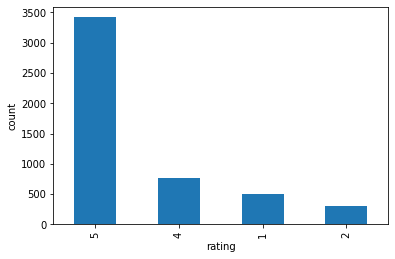

In [12]:
ax=filtered_Data.Score.value_counts().plot(kind='bar')
plt.xlabel("rating")
plt.ylabel("count")

In [13]:
def partition(x):
    if x<3:
        return 0
    return 1
actualscore=final['Score']
positiveNegative=actualscore.map(partition)
final['Score']=positiveNegative
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [14]:
print("Number of Positive reviews : ", final.Score.value_counts()[1])
print("Number of Negative reviews : ", final.Score.value_counts()[0])

Number of Positive reviews :  4178
Number of Negative reviews :  808


We can see from above analysis data is highly imbalanced.

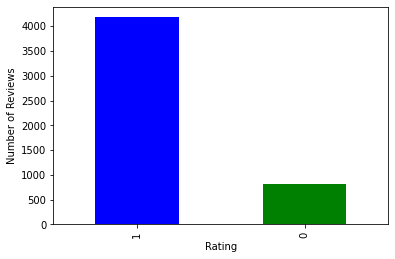

In [15]:
ax=final.Score.value_counts(sort=True).plot(kind='bar',xlabel='Rating',ylabel="Number of Reviews",color={"blue","green"})
#plt.xlabel("Rating")
#plt.ylabel("Number of reviews")

We can conclude from above barplot that data is highly imbalanced.

### Text Preprocessing

In text preprocessing we do the following:

1. Removal of HTML tag
2. Removing special character
3.coverting all text to lowercase
4. removing stopwords
5. stemming off word

## Preprocessing of Text attribute

In [16]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 2922.18it/s]


## Preprocessing of summary attribute

In [19]:
preprocessed_summary=[]
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 3004.10it/s]


### Featurization
In this we convert text into vector. We implement following method to change text into vector:

1. Bag of words
2.TF-IDF
3.Avg Word2vec
4.TFIDF-W2V

In [22]:
# Bag of words
def Bow(text_feature):
    count_vect=CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
    count_vect.fit(text_feature)
    final_counts=count_vect.transform(text_feature)
    print("the shape of out text Bow Vectorizer ",final_counts.get_shape())
    print("the number of unique words ", final_counts.get_shape()[1])
    return(final_count)


In [23]:
#TF-IDF implementation
def TFIDF(text_feature):
    tf_idf_vect=TfidfVectorizer(ngram_range=(1,2),min_df=10)
    tf_idf_vect.fit(text_feature)
    final_tf_idf=tf_idf_vect.transform(text_feature)
    return(final_tf_idf)
    



In [ ]:
#Word2vec
